In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 48.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import wandb and log in if necessary
import wandb
# Uncomment and run the next line if not already authenticated:
# wandb.login()

# Import your configurable CNN model (assumes model.py is in the same directory)
from model import ConfigurableCNN

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

project_path = "mrsagarbiswas-iit-madras/CNN_inaturalist_12K"  # <-- CHANGE THIS

api = wandb.Api()
runs = api.runs(project_path)

# We assume that each run’s summary contains a key "val_loss"
# Filter out runs that do not report this metric and then choose the best one
valid_runs = [run for run in runs if 'val_loss' in run.summary]
if not valid_runs:
    raise ValueError("No valid runs with 'val_loss' found in the wandb project.")

# Select the run with the lowest validation loss
best_run = min(valid_runs, key=lambda run: run.summary['val_loss'])
best_config = best_run.config

print("Best run found:")
print("Run ID:", best_run.id)
print("Validation Loss:", best_run.summary.get('val_loss'))
print("Configuration:", best_config)

from sklearn.model_selection import StratifiedShuffleSplit

# Define transforms for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Set base directory for the dataset (adjust the path as needed)
base_dir = "/content/drive/MyDrive/nature_12K/inaturalist_12K"  # <-- CHANGE THIS if needed
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Use ImageFolder for the training data. Here we first load file paths only.
full_train_dataset = ImageFolder(root=train_dir, transform=None, loader=lambda x: x)

# Get class labels from the dataset samples
labels = [label for _, label in full_train_dataset.samples]

# Create stratified split into training and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss.split(np.zeros(len(labels)), labels))

# Create a lazy loader dataset to load images on-demand
class LazyLoadDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.samples)

# Create datasets for training and validation
train_samples = [full_train_dataset.samples[i] for i in train_indices]
val_samples = [full_train_dataset.samples[i] for i in val_indices]

train_dataset = LazyLoadDataset(train_samples, transform=train_transforms)
val_dataset = LazyLoadDataset(val_samples, transform=val_transforms)

# Create the test dataset (using ImageFolder since images will be loaded on-demand)
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

# Create DataLoaders
batch_size = 64  # use batch_size from config if provided, default otherwise
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)


Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mrsagarbiswas (mrsagarbiswas-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Best run found:
Run ID: ry83slbo
Validation Loss: 1.746713399887085
Configuration: {'lr': 0.0005, 'config': {'lr': 0.0005, 'filters': [32, 64, 128, 256, 512], 'activation': 'ReLU', 'batch_size': 32, 'max_epochs': 20, 'dropout_rate': 0.2, 'kernel_sizes': [3, 3, 3, 3, 3], 'dense_neurons': 256, 'use_batchnorm': True, 'num_conv_layers': 5, 'dropout_rate_dense': 0.2}, 'filters': [32, 64, 128, 256, 512], 'activation': 'ReLU', 'batch_size': 32, 'max_epochs': 20, 'dropout_rate': 0.2, 'kernel_sizes': [3, 3, 3, 3, 3], 'dense_neurons': 256, 'use_batchnorm': True, 'num_conv_layers': 5, 'dropout_rate_dense': 0.2}


In [ ]:
# Convert best_config (which is a wandb.Config object/dict) to a plain dictionary if necessary
if isinstance(best_config, wandb.Config):
    best_config = dict(best_config)
else:
    best_config = dict(best_config)

print("Using configuration for training:")
print(best_config)

# Instantiate the model using the best configuration
model = ConfigurableCNN(best_config)
model = model.to(device)

# Define a PyTorch Lightning Trainer (adjust epochs and settings as needed)
max_epochs = best_config.get("max_epochs", 20)
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator='gpu' if device=='cuda' else 'cpu',
    precision=16 if device=='cuda' else 32,
    log_every_n_steps=10,
)

# Train the model
trainer.fit(model, train_loader, val_loader)

Using device: cuda
Best run found:
Run ID: ry83slbo
Validation Loss: 1.746713399887085
Configuration: {'lr': 0.0005, 'config': {'lr': 0.0005, 'filters': [32, 64, 128, 256, 512], 'activation': 'ReLU', 'batch_size': 32, 'max_epochs': 20, 'dropout_rate': 0.2, 'kernel_sizes': [3, 3, 3, 3, 3], 'dense_neurons': 256, 'use_batchnorm': True, 'num_conv_layers': 5, 'dropout_rate_dense': 0.2}, 'filters': [32, 64, 128, 256, 512], 'activation': 'ReLU', 'batch_size': 32, 'max_epochs': 20, 'dropout_rate': 0.2, 'kernel_sizes': [3, 3, 3, 3, 3], 'dense_neurons': 256, 'use_batchnorm': True, 'num_conv_layers': 5, 'dropout_rate_dense': 0.2}


/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | conv      | Sequential       | 1.6 M  | train
1 

Using configuration for training:
{'lr': 0.0005, 'config': {'lr': 0.0005, 'filters': [32, 64, 128, 256, 512], 'activation': 'ReLU', 'batch_size': 32, 'max_epochs': 20, 'dropout_rate': 0.2, 'kernel_sizes': [3, 3, 3, 3, 3], 'dense_neurons': 256, 'use_batchnorm': True, 'num_conv_layers': 5, 'dropout_rate_dense': 0.2}, 'filters': [32, 64, 128, 256, 512], 'activation': 'ReLU', 'batch_size': 32, 'max_epochs': 20, 'dropout_rate': 0.2, 'kernel_sizes': [3, 3, 3, 3, 3], 'dense_neurons': 256, 'use_batchnorm': True, 'num_conv_layers': 5, 'dropout_rate_dense': 0.2}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# Store the Model Locally
torch.save(model.state_dict(), 'model_state_dict.pth')

In [5]:
best_config = {
    "num_conv_layers": 5,
    "filters": [32, 64, 128, 256, 512],
    "kernel_sizes": [3, 3, 3, 3, 3],
    "activation": "ReLU",
    "use_batchnorm": True,
    "dropout_rate": 0.2,
    "dense_neurons": 256,
    "dropout_rate_dense": 0.3,
    "lr": 1e-3,
    "num_classes": 10  # make sure this matches your dataset!
}

# 2. Create the model using the config
model = ConfigurableCNN(best_config)

# 3. Load weights (not a full Lightning checkpoint!)
model.load_state_dict(torch.load('model_state_dict.pth', map_location='cpu'))
model = model.to(device)  # <--- this line is critical

In [6]:
def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    total, correct = 0, 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_loss = test_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

avg_loss, test_accuracy = evaluate_model(model, test_loader, device)
print(f"Test Loss: {avg_loss:.4f}  Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 1.8053  Test Accuracy: 37.60%


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


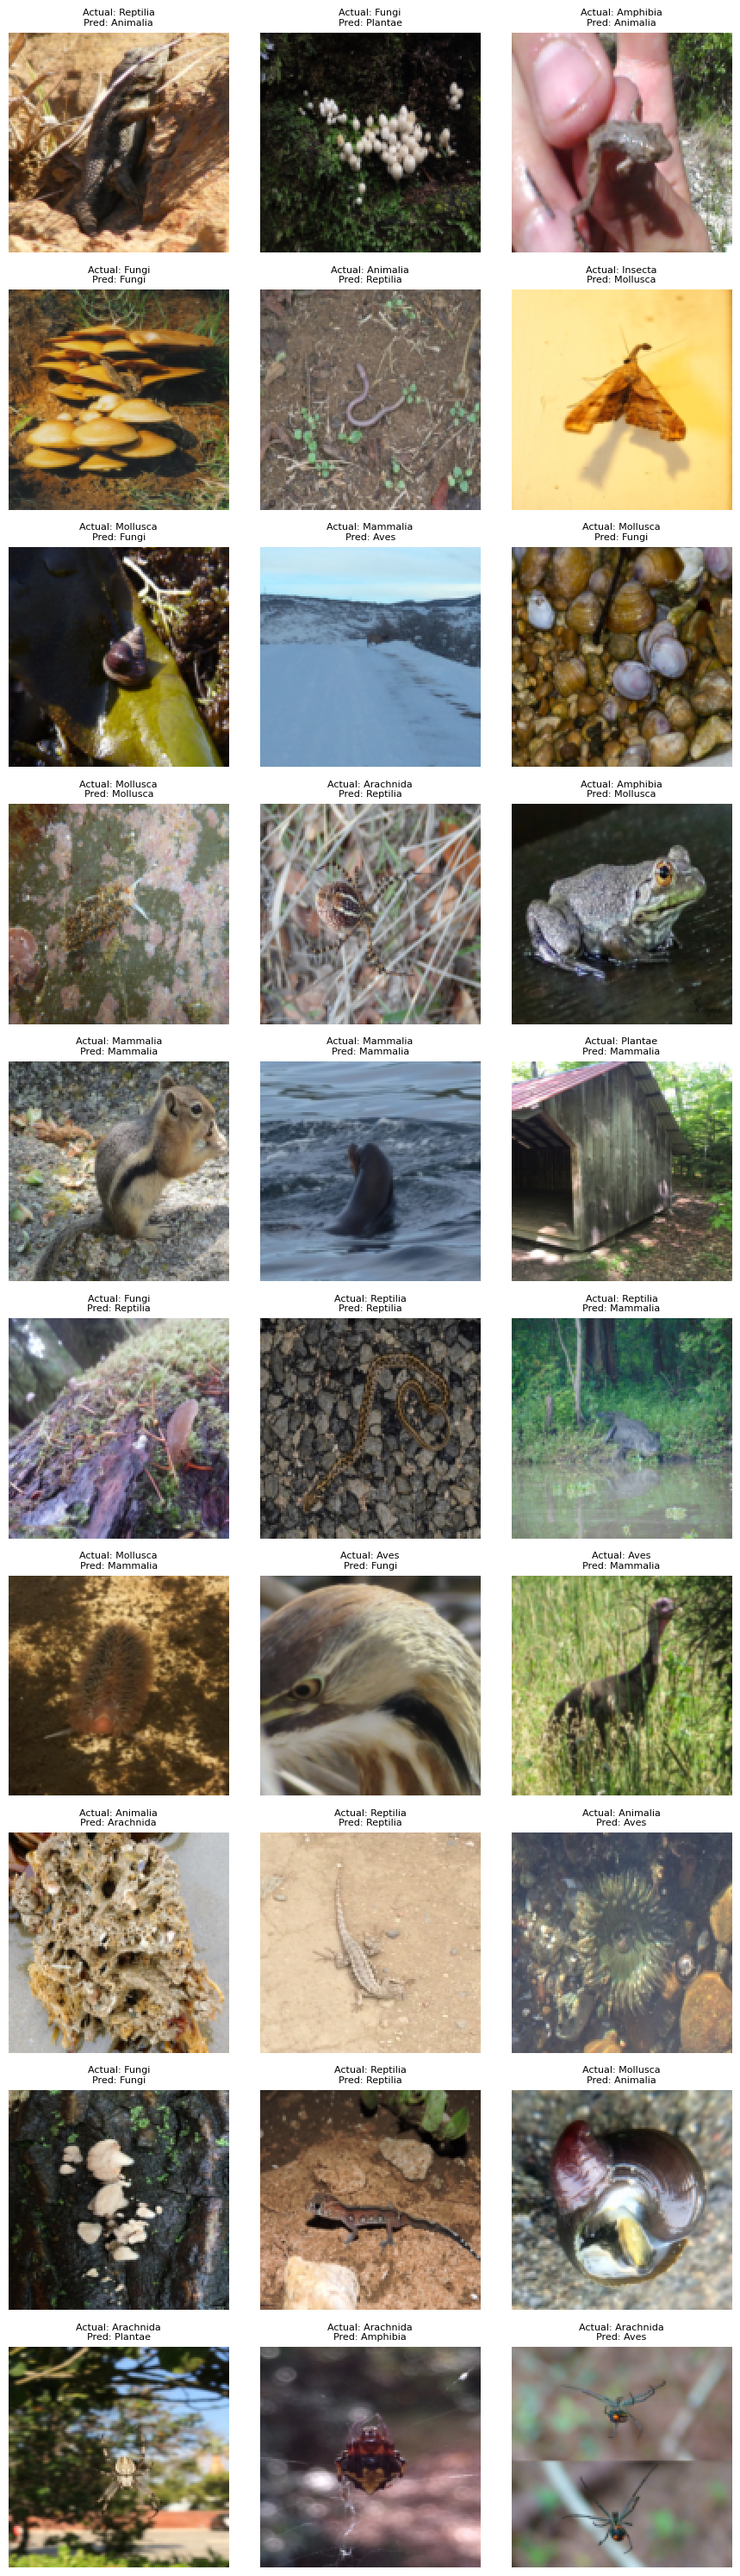

In [8]:
def plot_predictions_grid(model, dataset, device,
                         grid_rows=10, grid_cols=3):
    # --- Initialize or get your WandB run (if not already done) ---
    wandb.init(project="CNN_inaturalist_12K", name="test_predictions", reinit=True)

    model.eval()
    indices = random.sample(range(len(dataset)), grid_rows * grid_cols)
    fig, axes = plt.subplots(grid_rows, grid_cols,
                             figsize=(grid_cols*3, grid_rows*3))

    class_names = dataset.classes
    wb_images = []

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        input_img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_img)
            pred = output.argmax(dim=1).item()

        # prepare numpy image for matplotlib and WandB
        np_img = img.permute(1, 2, 0).cpu().numpy()

        # Matplotlib subplot
        ax = axes[i // grid_cols, i % grid_cols]
        ax.imshow(np.clip(np_img, 0, 1))
        ax.axis("off")
        actual = class_names[label]
        predicted = class_names[pred]
        ax.set_title(f"Actual: {actual}\nPred: {predicted}", fontsize=8)

        # prepare WandB Image with caption
        caption = f"Actual: {actual}  |  Pred: {predicted}"
        wb_images.append(wandb.Image(np_img, caption=caption))

    plt.tight_layout()

    # --- Log individual images as a list ---
    wandb.log({ "sample_predictions": wb_images })

    # --- Optionally: log the full grid plot too ---
    wandb.log({ "prediction_grid": wandb.Image(fig) })

    # finally, show the plot in‐notebook
    plt.show()

plot_predictions_grid(model, test_dataset, device)


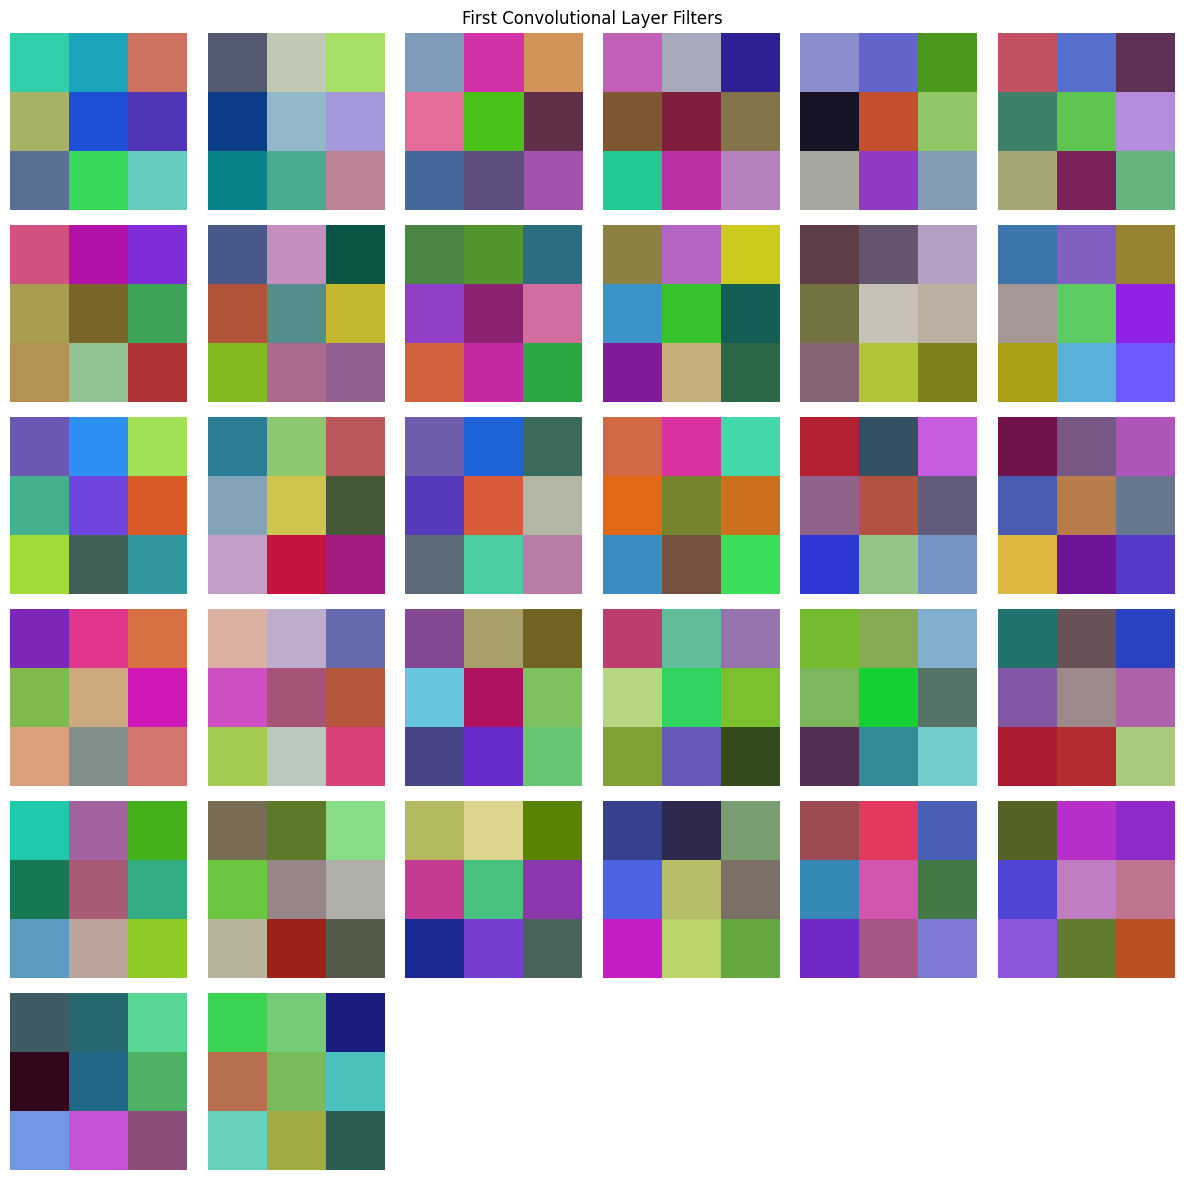

In [11]:
def visualize_first_layer_filters(model):
    # Find the first Conv2d layer in model.conv
    first_conv = None
    for layer in model.conv:
        if isinstance(layer, nn.Conv2d):
            first_conv = layer
            break
    if first_conv is None:
        print("No Conv2d layer found!")
        return

    # Get filter weights (out_channels, in_channels, k, k)
    filters = first_conv.weight.data.clone().cpu()
    out_channels = filters.shape[0]
    # Normalize filters to [0,1]
    filters = (filters - filters.min()) / (filters.max() - filters.min() + 1e-5)

    # Determine grid layout (e.g., 8×8 if 64 filters)
    grid_cols = int(np.ceil(np.sqrt(out_channels)))
    grid_rows = int(np.ceil(out_channels / grid_cols))

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*2, grid_rows*2))
    axes = np.array(axes).reshape(-1)

    for i in range(out_channels):
        ax = axes[i]
        filt = filters[i]
        # If filters are RGB, transpose to (H,W,Channels)
        if filt.shape[0] == 3:
            filt_img = filt.permute(1,2,0)
        else:
            filt_img = filt.squeeze(0)
        ax.imshow(filt_img.numpy())
        ax.axis("off")
    # Remove extra axes if any
    for ax in axes[out_channels:]:
        ax.remove()
    plt.suptitle("First Convolutional Layer Filters")
    plt.tight_layout()
    plt.show()

visualize_first_layer_filters(model)

In [13]:
class GuidedBackpropReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        positive_mask = (input > 0).type_as(input)
        output = input * positive_mask
        ctx.save_for_backward(positive_mask)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        positive_mask, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[grad_output < 0] = 0
        return grad_input * positive_mask

def register_guided_backprop_hooks(model):
    hooks = []
    def backward_hook(module, grad_in, grad_out):
        grad = grad_in[0]
        grad[grad < 0] = 0
        return (grad,)
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            hook = module.register_backward_hook(backward_hook)
            hooks.append(hook)
    return hooks

# Register guided backprop hooks
guidedback_hooks = register_guided_backprop_hooks(model)

Registered guided backprop hooks on ReLU layers.
Using CONV5 layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Selected neuron indices in conv5: [103, 60, 511, 77, 445, 341, 325, 471, 418, 400]


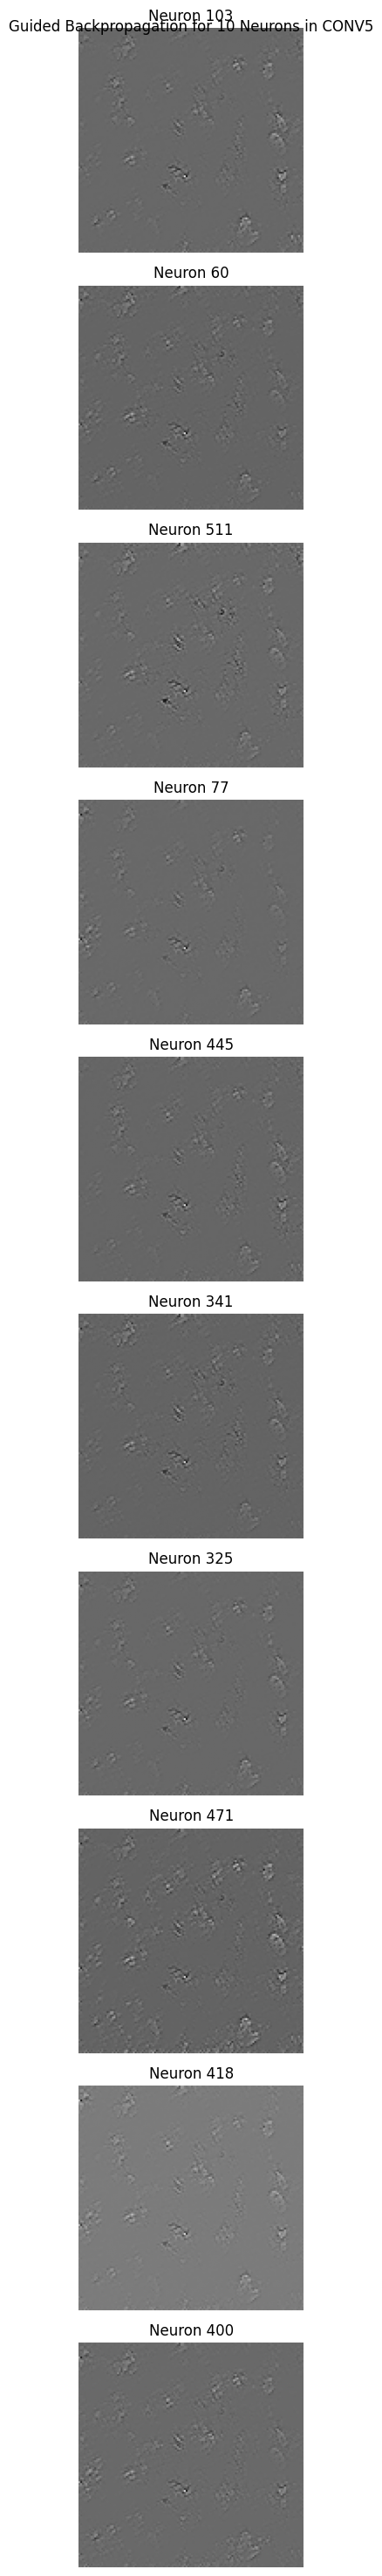

In [14]:
print("Registered guided backprop hooks on ReLU layers.")
# Identify the target layer: we select the 5th convolutional block (CONV5).
def get_conv5_layer(model):
    conv_count = 0
    for layer in model.conv:
        if isinstance(layer, nn.Conv2d):
            conv_count += 1
            if conv_count == 5:
                return layer
    return None

conv5_layer = get_conv5_layer(model)
if conv5_layer is None:
    raise ValueError("CONV5 layer not found in model.conv.")

print("Using CONV5 layer:", conv5_layer)

# For guided backprop we need an input image. We select one random test image.
input_img, _ = test_dataset[random.randint(0, len(test_dataset)-1)]
input_img = input_img.unsqueeze(0).to(device)
input_img.requires_grad = True

# Use a mutable container (list) to store activation from conv5
activation = [None]
def hook_conv5(module, input, output):
    activation[0] = output
hook_handle = conv5_layer.register_forward_hook(hook_conv5)

# Forward pass: get activation from conv5
output = model(input_img)
hook_handle.remove()  # Remove hook after forward pass

if activation[0] is None:
    raise ValueError("Could not get activation from conv5 layer.")

# Pick 10 random neurons (channels) from conv5
num_channels = activation[0].shape[1]
selected_indices = random.sample(range(num_channels), 10)
print("Selected neuron indices in conv5:", selected_indices)

def guided_backprop_for_neuron(model, input_img, neuron_index, conv_layer):
    model.zero_grad()

    # Use a mutable container to capture activation
    activation_temp = [None]
    def hook_conv(module, inp, out):
        activation_temp[0] = out
    hook = conv_layer.register_forward_hook(hook_conv)
    output = model(input_img)
    hook.remove()

    if activation_temp[0] is None:
        raise ValueError("Activation not captured.")

    # Use the activation map for the selected neuron channel and compute the mean activation as target.
    neuron_activation = activation_temp[0][0, neuron_index]
    target = neuron_activation.mean()

    # Backward pass to compute gradients with respect to input.
    target.backward(retain_graph=True)
    grad = input_img.grad.data.clone().cpu().squeeze(0)
    # Normalize gradients to [0,1]
    grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-5)
    return grad

guided_images = []
for idx in selected_indices:
    model.zero_grad()
    if input_img.grad is not None:
        input_img.grad.data.zero_()
    grad = guided_backprop_for_neuron(model, input_img, idx, conv5_layer)
    # Convert the gradient to grayscale by taking the mean over channels.
    guided_img = grad.mean(dim=0).numpy()
    guided_images.append(guided_img)

# Remove any guided backprop hooks if previously registered (if any)
# (Assuming you stored them in a list, you can call hook.remove() for each.)

# Plot the guided backprop images in a 10x1 grid.
fig, axes = plt.subplots(10, 1, figsize=(4, 30))
for i, img in enumerate(guided_images):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Neuron {selected_indices[i]}")
plt.suptitle("Guided Backpropagation for 10 Neurons in CONV5")
plt.tight_layout()
plt.show()


In [15]:
# At the top of your script, before you compute guided_images:
wandb.init(project="CNN_inaturalist_12K", name="guided_conv5_neurons", reinit=True)

# Build a list of WandB Image objects with captions
wb_imgs = [
    wandb.Image(img, caption=f"Neuron {idx}")
    for idx, img in zip(selected_indices, guided_images)
]

# Log the individual guided‐backprop maps
wandb.log({ "guided_conv5_neurons": wb_imgs })

# Optionally: log the full matplotlib grid as well
wandb.log({ "guided_conv5_grid": wandb.Image(fig) })
